<a href="https://colab.research.google.com/github/billbch/Clasification-posture/blob/main/Mobilenetv2_clasificador_de_buena_o_mala_postura_sentado_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir sitting_well
!mkdir sitting_wrong

In [ ]:
%cd sitting_well
!unzip sitting_well.zip
%cd ..

%cd sitting_wrong
!unzip sitting_wrong.zip
%cd ..


In [3]:
#borrar zips
!rm -rf /content/sitting_well/sitting_well.zip
!rm -rf /content/sitting_wrong/sitting_wrong.zip

In [4]:
#mostrar cantidad de im de c/u
!ls /content/sitting_well | wc -l #103
!ls /content/sitting_wrong | wc -l #259

103
259


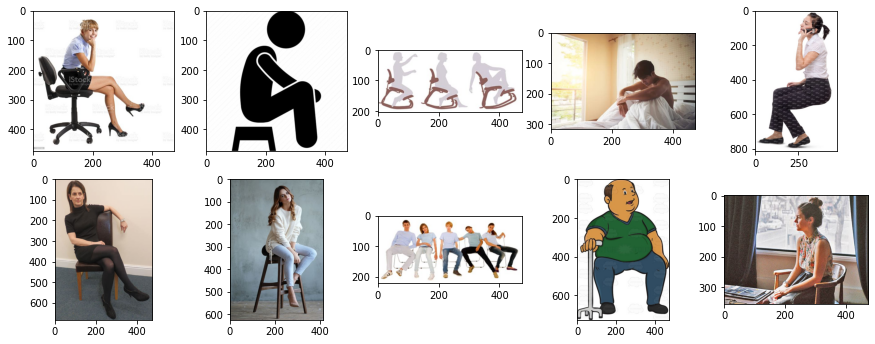

In [5]:
#ver imagenes
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = '/content/sitting_wrong'
imagenes = os.listdir(carpeta)
for i, nombreimg in enumerate(imagenes[:10]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

In [6]:
#borrar zips
!rm -rf /content/dataset

In [7]:
#crear crpeta dataset

!mkdir dataset
!mkdir dataset/sitting_well
!mkdir dataset/sitting_wrong

In [8]:
#copiar imagenes originales a la carpeta dataset
#con misma cantidad
import shutil

carpeta_fuente = '/content/sitting_well'
carpeta_destino = '/content/dataset/sitting_well'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i<103:
    #copiar de fuente a destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)


In [9]:
#copiar imagenes originales a la carpeta dataset
#con misma cantidad
import shutil

carpeta_fuente = '/content/sitting_wrong'
carpeta_destino = '/content/dataset/sitting_wrong'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i<103:
    #copiar de fuente a destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)
    

In [ ]:
#mostrar cantidad de im de c/u del nuevo datset
!ls /content/dataset/sitting_well | wc -l #
!ls /content/dataset/sitting_wrong | wc -l #

103
103


In [10]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#crear dataset generator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=15,
    zoom_range=[0.5,1.5],
    validation_split=0.2 #20% para pruebas
    )

data_gen_entrenamiento = datagen.flow_from_directory('/content/dataset',target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')

data_gen_pruebas = datagen.flow_from_directory('/content/dataset',target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')


Found 166 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


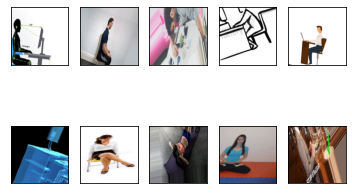

In [11]:
#imprimir 10 img del generador de entrenamiento
for image, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i])
  break
plt.show()

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobilenetv2 = hub.KerasLayer(url,input_shape=(224,224,3))

In [13]:
#congelar el modelo descargado
mobilenetv2.trainable = False

In [14]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(2,activation='softmax')
])

In [15]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
#compilar
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [17]:
EPOCAS=50

historial = modelo.fit(data_gen_entrenamiento, epochs=EPOCAS,batch_size=32,
                       validation_data= data_gen_pruebas)

Epoch 1/50
6/6 [==============================] - 13s 694ms/step - loss: 0.8761 - accuracy: 0.5422 - val_loss: 0.6466 - val_accuracy: 0.6750
Epoch 2/50
6/6 [==============================] - 3s 443ms/step - loss: 0.8063 - accuracy: 0.5482 - val_loss: 0.7467 - val_accuracy: 0.5750
Epoch 3/50
6/6 [==============================] - 3s 439ms/step - loss: 0.7464 - accuracy: 0.6145 - val_loss: 0.6905 - val_accuracy: 0.6000
Epoch 4/50
6/6 [==============================] - 3s 438ms/step - loss: 0.6431 - accuracy: 0.6205 - val_loss: 0.7072 - val_accuracy: 0.5750
Epoch 5/50
6/6 [==============================] - 3s 443ms/step - loss: 0.6402 - accuracy: 0.6205 - val_loss: 0.6786 - val_accuracy: 0.6250
Epoch 6/50
6/6 [==============================] - 3s 509ms/step - loss: 0.6658 - accuracy: 0.6205 - val_loss: 0.5586 - val_accuracy: 0.6750
Epoch 7/50
6/6 [==============================] - 3s 439ms/step - loss: 0.6795 - accuracy: 0.6325 - val_loss: 0.4910 - val_accuracy: 0.7250
Epoch 8/50
6/6 [===

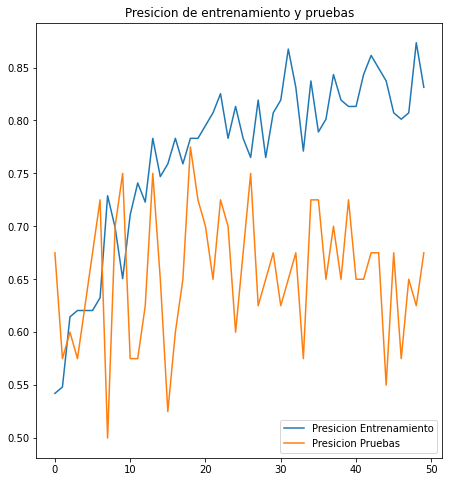

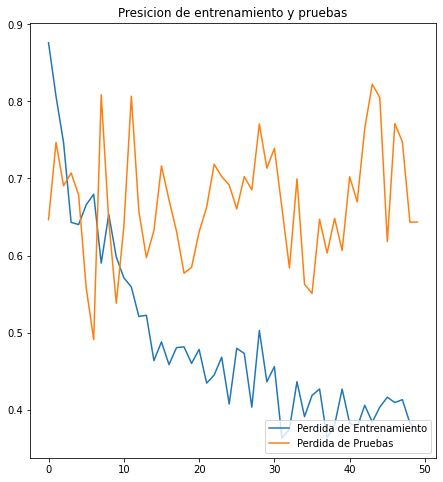

In [39]:
#Gracias
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Presicion Entrenamiento')
plt.plot(rango_epocas, val_acc,label='Presicion Pruebas')
plt.legend(loc='lower right')
plt.title('Presicion de entrenamiento y pruebas')
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, loss, label='Perdida de Entrenamiento')
plt.plot(rango_epocas, val_loss,label='Perdida de Pruebas')
plt.legend(loc='lower right')
plt.title('Presicion de entrenamiento y pruebas')
plt.show()


In [19]:
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1,224,224,3))
  return np.argmax(prediccion[0],axis=-1)


In [38]:
#0 = bien #1 = mal
url='https://i.ibb.co/ZzYJk45/Whats-App-Image-2022-11-10-at-10-45-36-PM-2.jpg'
prediccion = categorizar(url)
print(prediccion)

1/1 [==============================] - 0s 20ms/step
1
